<a href="https://colab.research.google.com/github/pranay2310/Credit-Card-Default-Prediction/blob/main/Credit_Card_Default_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting whether a customer will default on his/her credit card </u></b>

## <b> Problem Description </b>

### This project is aimed at predicting the case of customers default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. We can use the [K-S chart](https://www.listendata.com/2019/07/KS-Statistics-Python.html) to evaluate which customers will default on their credit card payments


## <b> Data Description </b>

### <b>Attribute Information: </b>

### This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* ### X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* ### X2: Gender (1 = male; 2 = female).
* ### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* ### X4: Marital status (1 = married; 2 = single; 3 = others).
* ### X5: Age (year).
* ### X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* ### X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* ### X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score


#import xlrd

In [3]:
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 4.2 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [4]:
import xlrd

In [5]:
df = pd.read_excel("/content/drive/MyDrive/Almabetter/Capstone project/Credit Card Default Prediction/default_of_credit_card_clients.xls",sheet_name="Data",engine="xlrd", header=1)

In [6]:
df.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
118,119,400000,1,2,1,34,-1,-1,-1,-1,...,7839,14837,7959,9677,11867,7839,14837,7959,5712,0
7547,7548,330000,2,2,1,37,-2,-2,-2,-2,...,3119,0,7255,0,3080,3119,0,7255,9060,0
1428,1429,210000,2,1,1,37,2,2,2,2,...,80399,81462,83366,3700,3000,3200,2500,3400,4300,1
25802,25803,150000,2,3,2,38,0,0,-1,2,...,530,1696,1166,150,530,0,1166,0,0,0
26978,26979,80000,1,1,2,42,5,4,3,2,...,56788,52287,52287,0,0,0,0,0,50771,0


#Data Cleaning

In [7]:
#Value in EDUCATION not define completely. Since 0, 4, 5, 6 all being define as other (or unknown), will be better to group them together and name it 4.
fill = (df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6)
df.loc[fill, 'EDUCATION'] = 4

print('EDUCATION ' + str(sorted(df['EDUCATION'].unique())))

EDUCATION [1, 2, 3, 4]


In [8]:
#Column name 'default payment next month' is better to name it 'DEFAULT'. Shorter and without dot that could probably cause error in code.
#Column name 'PAY_0' would be better to name it 'PAY_1', to make it consistent with 'BILL_AMT1' and 'PAY_AMT1'.

df = df.rename(columns={'default payment next month': 'DEFAULT', 
                        'PAY_0': 'PAY_1'})
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
df.shape

(30000, 25)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

observation:
There is no null value present in data set.
All Datatype in integer format.

#Handling discrepancy in data

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.842267,0.744494,1.0,1.00,2.0,2.00,4.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


There are some contradicting data in the dataset. It could be error when building up the data, or incomplete definition and explanation. Althought there is additional information in discussion, still couldn't explain all.



1. One of the contradicting information is those who Paid in Full in recent    month, turn out to be default
2. Some client paid more than they should be, resulting a Negative Bill Amount. But still end up being default.
3. Some client Bill Amount is much higher than their Credit Limit provided, which seldom happen in real case.





In [12]:
error1 = df.query('BILL_AMT1 < 0 and DEFAULT == 1').loc[:,('ID','BILL_AMT1','DEFAULT')]
error1.sample(5)

,ID,BILL_AMT1,DEFAULT
28666,28667,-124,1
27043,27044,-4,1
23550,23551,-10,1
216,217,-946,1
17307,17308,-149,1


In [13]:
error2 = df.query('BILL_AMT1 > LIMIT_BAL').loc[:,('ID','LIMIT_BAL','BILL_AMT1')]
error2.sample(5)

,ID,LIMIT_BAL,BILL_AMT1
26600,26601,30000,41300
7174,7175,20000,25274
8285,8286,30000,30527
27851,27852,70000,71832
29196,29197,50000,50343


# Univariant Analysis

In [14]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [15]:
#Check unique value of each categorical variable
print('SEX' + str(sorted(df['SEX'].unique())))
print('EDUCATION' + str(sorted(df['EDUCATION'].unique())))
print('MARRIAGE' + str(sorted(df['MARRIAGE'].unique())))
print('PAY_1' + str(sorted(df['PAY_1'].unique())))
print('DEFAULT' + str(sorted(df['DEFAULT'].unique())))

SEX[1, 2]
EDUCATION[1, 2, 3, 4]
MARRIAGE[0, 1, 2, 3]
PAY_1[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
DEFAULT[0, 1]


##Column 2 : 'LIMIT_BAL'

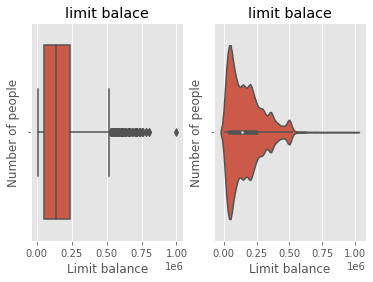

In [16]:
plt.subplot(1, 2, 1) # index 1
sns.boxplot(x= "LIMIT_BAL", data=df)
plt.xlabel("Limit balance")
plt.ylabel("Number of people")
plt.title("limit balace")


plt.subplot(1, 2, 2) # index 2
sns.violinplot(df["LIMIT_BAL"], orient="h")
plt.xlabel("Limit balance")
plt.ylabel("Number of people")
plt.title("limit balace")

plt.show()

<function matplotlib.pyplot.show>

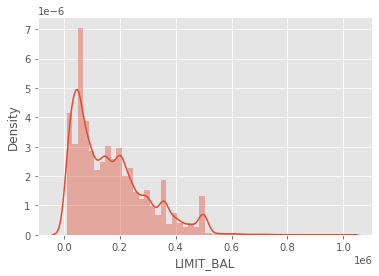

In [17]:
sns.distplot(df.LIMIT_BAL)
plt.ticklabel_format(useOffset=False)
plt.show

##Column 3: SEX

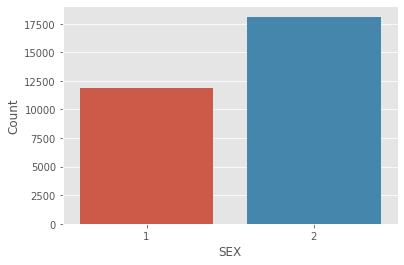

In [18]:
sns.countplot(df.SEX)
plt.xlabel('SEX')
plt.ylabel('Count')
plt.show()

## column 4: EDUCATION

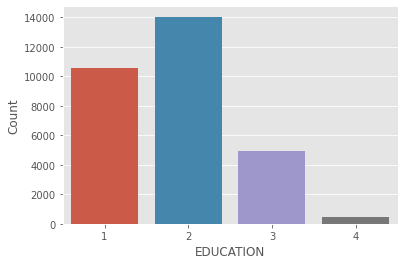

In [19]:
sns.countplot(df.EDUCATION)
plt.xlabel('EDUCATION')
plt.ylabel('Count')
plt.show()

## Column 5: Marriage

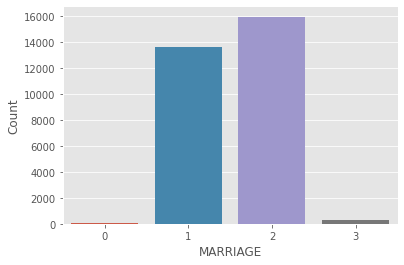

In [20]:
sns.countplot(df.MARRIAGE)
plt.xlabel('MARRIAGE')
plt.ylabel('Count')
plt.show()

## Column 6: AGE

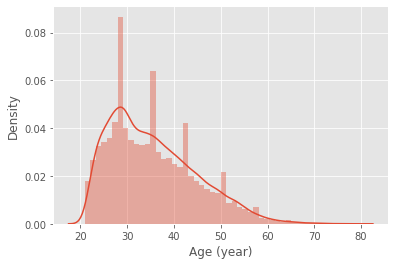

In [21]:
sns.distplot(df.AGE)
plt.xlabel("Age (year)")
#plt.ylabel("Number of people")
plt.show()

## COLUMN 7 to 12:

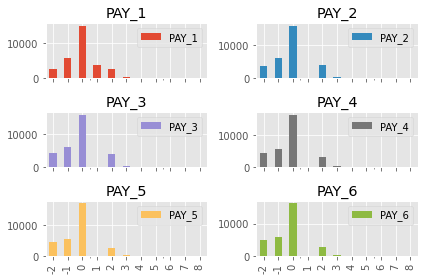

In [22]:
df.iloc[:,6:12].apply(pd.value_counts).plot(kind="bar", subplots=True, layout=(3,2), legend=True)

plt.tight_layout()  
plt.show()

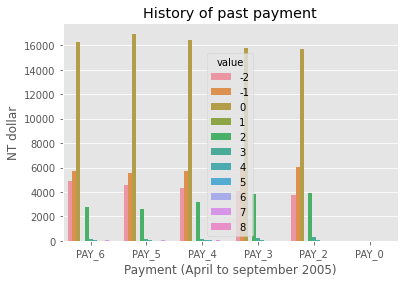

In [23]:
sns.countplot(x="variable", hue="value", data=pd.melt(df.iloc[:,6:12]), order = ["PAY_6","PAY_5","PAY_4","PAY_3","PAY_2","PAY_0"] )
plt.title("History of past payment")
plt.xlabel("Payment (April to september 2005)")
plt.ylabel("NT dollar")
plt.show()

## column 13 to 18 :

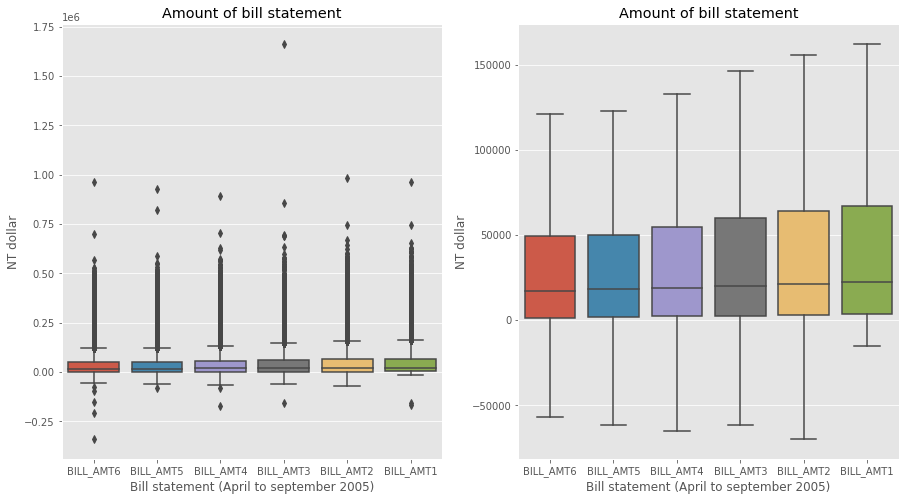

In [24]:
plt.rcParams["figure.figsize"] = [15,8]
plt.subplot(1, 2, 1) # index 1
sns.boxplot( data=df.iloc[:,12:18], 
            order=["BILL_AMT6","BILL_AMT5","BILL_AMT4","BILL_AMT3","BILL_AMT2","BILL_AMT1"])
plt.title("Amount of bill statement")
plt.xlabel("Bill statement (April to september 2005)")
plt.ylabel("NT dollar")


plt.subplot(1, 2, 2) # index 2
sns.boxplot( data=df.iloc[:,12:18],
            showfliers=False,
            order=["BILL_AMT6","BILL_AMT5","BILL_AMT4","BILL_AMT3","BILL_AMT2","BILL_AMT1"])
plt.title("Amount of bill statement")
plt.xlabel("Bill statement (April to september 2005)")
plt.ylabel("NT dollar")

plt.show()            


## column 19 to 24

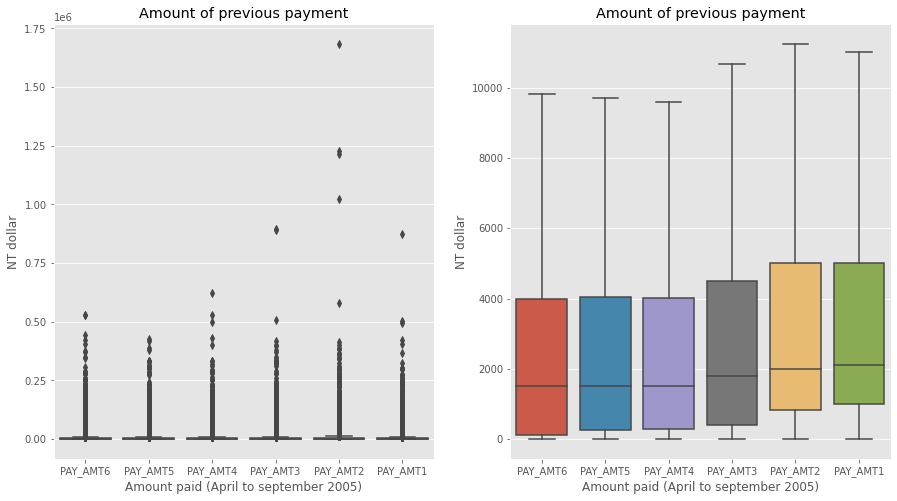

In [25]:
plt.rcParams["figure.figsize"] = [15,8]
plt.subplot(1, 2, 1) # index 1
sns.boxplot( data=df.iloc[:,18:24], 
            order=["PAY_AMT6","PAY_AMT5","PAY_AMT4","PAY_AMT3","PAY_AMT2","PAY_AMT1"])
plt.title("Amount of previous payment")
plt.xlabel("Amount paid (April to september 2005)")
plt.ylabel("NT dollar")


plt.subplot(1, 2, 2) # index 2
sns.boxplot( data=df.iloc[:,18:24],
            showfliers=False,
            order=["PAY_AMT6","PAY_AMT5","PAY_AMT4","PAY_AMT3","PAY_AMT2","PAY_AMT1"])
plt.title("Amount of previous payment")
plt.xlabel("Amount paid (April to september 2005)")
plt.ylabel("NT dollar")

plt.show()

## column 25: DEFAULT

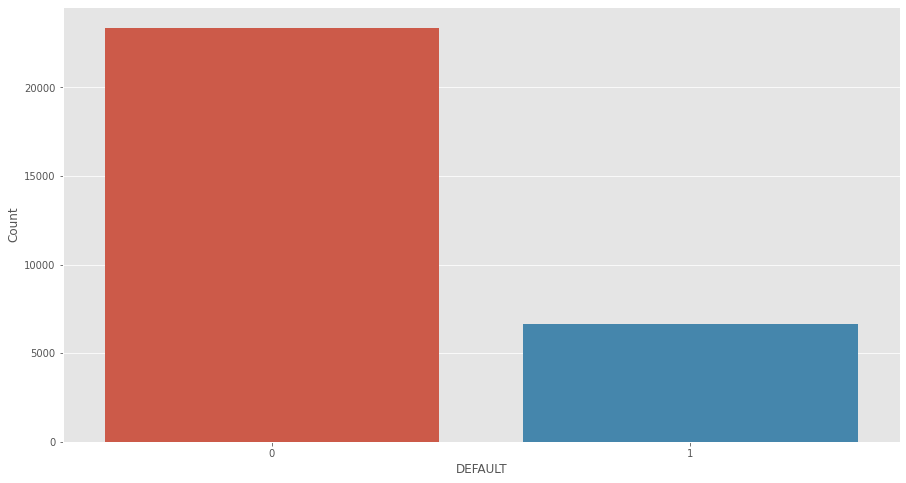

In [26]:
sns.countplot(df.DEFAULT)
plt.xlabel('DEFAULT')
plt.ylabel('Count')
plt.show()

# Bivariant analysis

In [27]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


##LIMIT_BAL vs Default

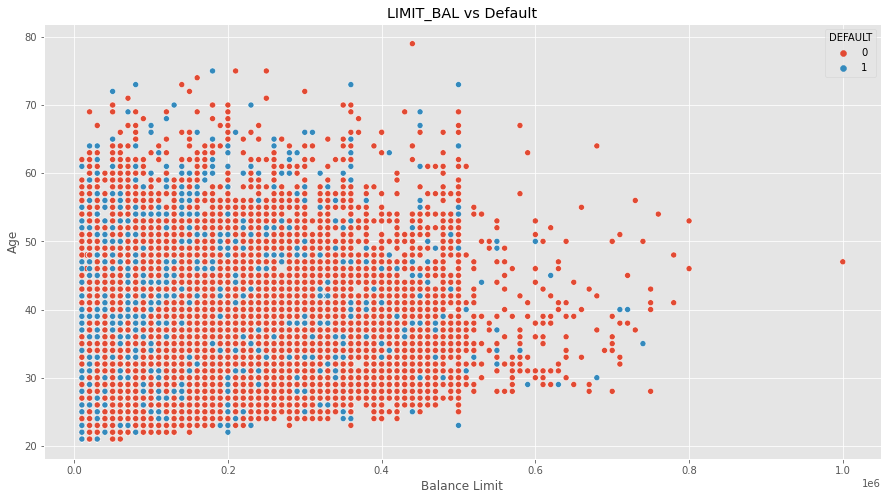

In [28]:
sns.scatterplot(x = "LIMIT_BAL", y = "AGE",data=df, hue='DEFAULT')
plt.xlabel('Balance Limit')
plt.ylabel('Age')
plt.title("LIMIT_BAL vs Default")
plt.show()

## SEX vs Default#

In [29]:
#Gender (1 = male; 2 = female)
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

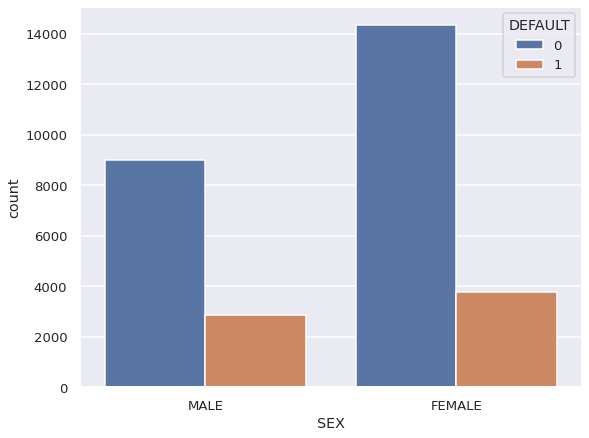

In [30]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)

gen = sns.countplot(x='SEX', hue='DEFAULT', data=df)
gen.set_xticklabels(['MALE','FEMALE'])
plt.show()

In [31]:
default0 = df.groupby(df['SEX'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['SEX'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('SEX').size().reset_index(name='TOTAL')

genTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
genTable['SEX'] = ['Male','Female']

genTable

,SEX,NOT_DEFAULT,DEFAULT,TOTAL
0,Male,9015,2873,11888
1,Female,14349,3763,18112


##Education vs DEFAULT

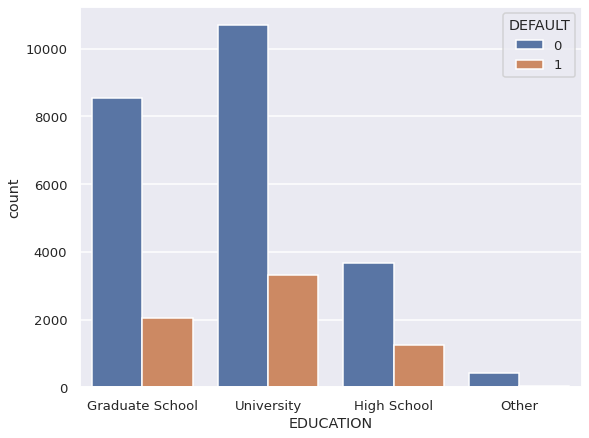

In [32]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)
# fdmkl
edu = sns.countplot(x='EDUCATION', hue='DEFAULT', data=df)
edu.set_xticklabels(['Graduate School','University','High School','Other'])
plt.show()

In [33]:
default0 = df.groupby(df['EDUCATION'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['EDUCATION'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('EDUCATION').size().reset_index(name='TOTAL')
#sxcxa
eduTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
eduTable['EDUCATION'] = ['Graduate School','University','High School','Other']

eduTable

,EDUCATION,NOT_DEFAULT,DEFAULT,TOTAL
0,Graduate School,8549,2036,10585
1,University,10700,3330,14030
2,High School,3680,1237,4917
3,Other,435,33,468


In [34]:
eduTable['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
eduTable['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)
# DFSDF
eduPct = eduTable.iloc[:,0:3]
eduPct = eduPct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

eduPct

,EDUCATION,NOT_DEFAULT(%),DEFAULT(%)
0,Graduate School,80.77,19.23
1,University,76.27,23.73
2,High School,74.84,25.16
3,Other,92.95,7.05


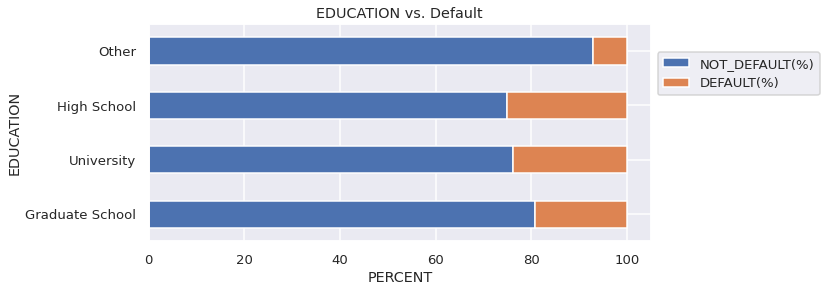

In [35]:
sns.set(rc={'figure.figsize':(9,4)})
sns.set_context("talk", font_scale=0.8)
#ASD
ax = eduPct.plot(x='EDUCATION', kind='barh', stacked=True, title='EDUCATION vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))
plt.show()

Although the Default Count for High School is lower than Graduate School & University. But in terms of Default Percentage, those with High School level have higher chance of Default.

# Marriage vs. Default

In [36]:
#Value in EDUCATION not define completely. Since 0, 4, 5, 6 all being define as other (or unknown), will be better to group them together and name it 4.
fill = (df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6)
df.loc[fill, 'EDUCATION'] = 4

print('EDUCATION ' + str(sorted(df['EDUCATION'].unique())))

EDUCATION [1, 2, 3, 4]


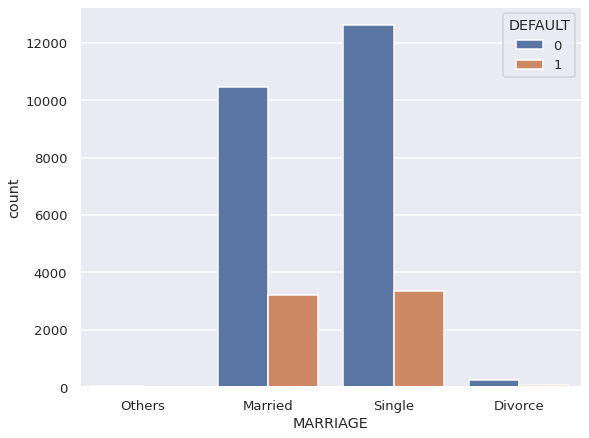

In [37]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)

marri = sns.countplot(x="MARRIAGE", hue='DEFAULT', data=df )
marri.set_xticklabels(['Others','Married','Single','Divorce'])
plt.show()

In [38]:
default0 = df.groupby(df['MARRIAGE'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['MARRIAGE'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('MARRIAGE').size().reset_index(name='TOTAL')

marriTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
marriTable['MARRIAGE'] = ['Others','Married','Single','Divorce']

marriTable

,MARRIAGE,NOT_DEFAULT,DEFAULT,TOTAL
0,Others,49,5,54
1,Married,10453,3206,13659
2,Single,12623,3341,15964
3,Divorce,239,84,323


In [39]:
marriTable['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
marriTable['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)

marriPct = marriTable.iloc[:,0:3]
marriPct = marriPct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

marriPct

,MARRIAGE,NOT_DEFAULT(%),DEFAULT(%)
0,Others,90.74,9.26
1,Married,76.53,23.47
2,Single,79.07,20.93
3,Divorce,73.99,26.01


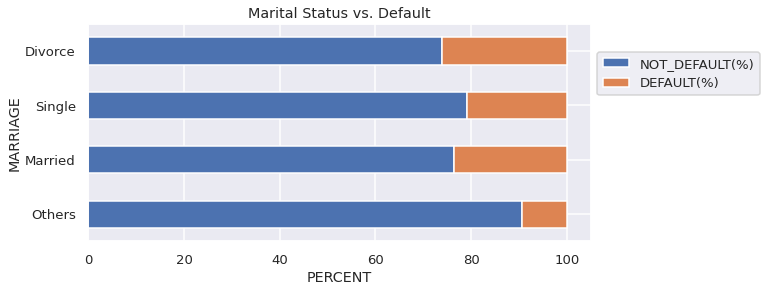

In [40]:
sns.set(rc={'figure.figsize':(9,4)})
sns.set_context("talk", font_scale=0.8)

ax = marriPct.plot(x='MARRIAGE', kind='barh', stacked=True, title='Marital Status vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))
plt.show()

Although the Default Count for Divorce is way lower than Single & Married. But in terms of Default Percentage, those who Divorce have higher chance of Default.

# Age vs. Default

In [41]:
df['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

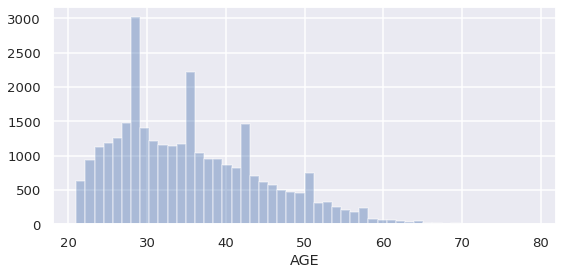

In [42]:
sns.distplot(df['AGE'], norm_hist=False, kde=False);

# CORRELATION

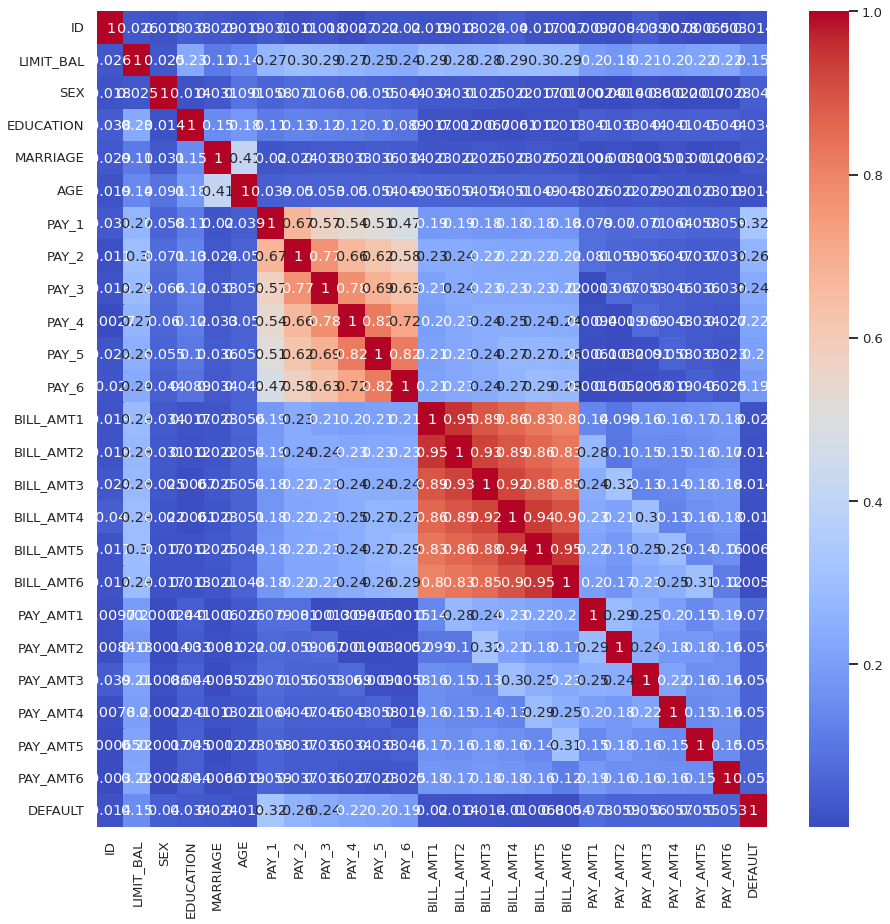

In [43]:
## Correlation
plt.figure(figsize=(15,15))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')
plt.show()

#One hot encoding

In [44]:
# One hot encoding
df = pd.get_dummies(df, columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [45]:
df.columns

Index(['ID', 'LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT', 'SEX_1', 'SEX_2',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')

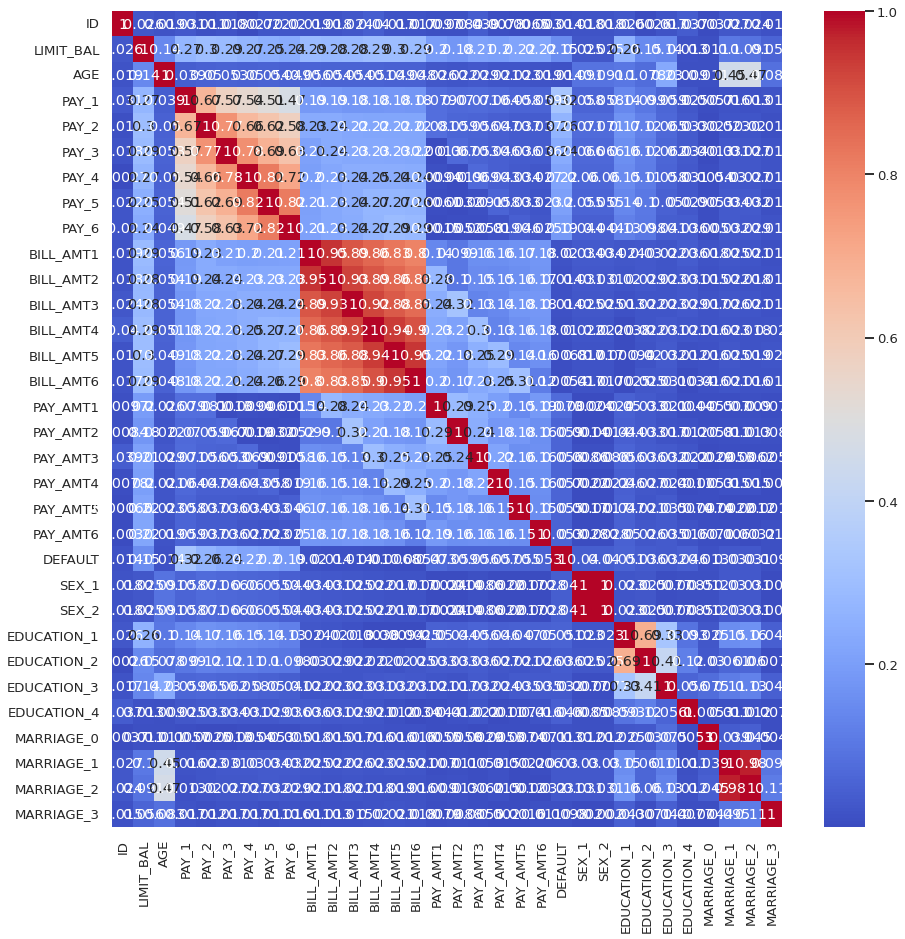

In [46]:
## Correlation
plt.figure(figsize=(15,15))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')
plt.show()

In [47]:
df.head()

,ID,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,0,1,0,1,0,0,0,1,0,0
1,2,120000,26,-1,2,0,0,0,2,2682,...,0,1,0,1,0,0,0,0,1,0
2,3,90000,34,0,0,0,0,0,0,29239,...,0,1,0,1,0,0,0,0,1,0
3,4,50000,37,0,0,0,0,0,0,46990,...,0,1,0,1,0,0,0,1,0,0
4,5,50000,57,-1,0,-1,0,0,0,8617,...,1,0,0,1,0,0,0,1,0,0


In [48]:
df.shape

(30000, 32)

#splitting data into train and test

In [49]:
# Data for all the independent variables
X = df.drop(labels='DEFAULT',axis=1)

# Data for the dependent variable
y = df['DEFAULT']

In [50]:
print(f'dimension of independent variable X is {X.shape}')
print(f'dimension of dependent variable Y is {y.shape}')

dimension of independent variable X is (30000, 31)
dimension of dependent variable Y is (30000,)


#data imbalance

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2)
X_sm, y_sm = smote.fit_resample(X, y)

In [52]:
y_sm=pd.DataFrame(y_sm)

In [53]:
y_sm.value_counts()

DEFAULT
0          23364
1          23364
dtype: int64

#spilt data

In [54]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X_sm,y_sm , test_size = 0.2, random_state = 0) 
print(f'dimension of train set {X_train.shape}')
print(f'dimension of test set {X_test.shape}')

dimension of train set (37382, 31)
dimension of test set (9346, 31)


In [55]:
print(f'dimension of y_train set {y_train.shape}')
print(f'dimension of Y_test set {y_test.shape}')

dimension of y_train set (37382, 1)
dimension of Y_test set (9346, 1)


#function

In [56]:
train_accuracy_list = []
test_accuracy_list = []
precision_train_list = []
precision_test_list= []
Recall_train_list= []
Recall_test_list = []
f1_score_train_list = []
f1_score_test_list = []
ROC_AUC_test_list = []

def validation_matrix(y_train, train_preds, y_test, test_preds, test_pred_pro, model_name):
  train_accuracy_1 = accuracy_score(train_preds,y_train)
  test_accuracy_1 = accuracy_score(test_preds,y_test)
  precision_train_1 = precision_score(y_train, train_preds)
  precision_test_1 = precision_score(y_test, test_preds)
  recall_score_train = recall_score(y_train, train_preds)
  recall_score_test = recall_score(y_test, test_preds)
  f1_score_train1 = f1_score(y_train, train_preds)
  f1_score_test1 = f1_score(y_test, test_preds)
  roc_auc = roc_auc_score(y_test,test_pred_pro)
  print(f'scoring matrix for {model_name}')
  print("="*20)
  print("The accuracy on train data is ", round(train_accuracy_1,3))
  print("The accuracy on test data is ", round(test_accuracy_1,3))
  print("The precision on train data is ", round(precision_train_1,3))
  print("The precision on test data is ", round(precision_test_1,3))
  print("The recall on train data is ", round(recall_score_train,3))
  print("The recall on test data is ", round(recall_score_test,3))
  print("The f1-score on train data is ", round(f1_score_train1,3))
  print("The f1-score on test data is ", round(f1_score_test1,3))
  print(f' ROC AUC score: {round(roc_auc,3)}')

  train_accuracy_list.append(round(train_accuracy_1,3))
  test_accuracy_list.append(round(test_accuracy_1,3))
  precision_train_list.append(round(precision_train_1,3))
  precision_test_list.append(round(precision_test_1,3))
  Recall_train_list.append(round(recall_score_train,3))
  Recall_test_list.append(round(recall_score_test,3))
  f1_score_train_list.append(round(f1_score_train1,3))
  f1_score_test_list.append(round(f1_score_test1,3))
  ROC_AUC_test_list.append(round(roc_auc,3))

#model building

##logistic regression

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(fit_intercept=True,max_iter=10000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [58]:
# Get the predicted probabilities
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [59]:
# Get the accuracy scores
train_accuracy = accuracy_score(train_preds,y_train)
test_accuracy = accuracy_score(test_preds,y_test)

print("The accuracy on train data is ", train_accuracy)
print("The accuracy on test data is ", test_accuracy)

The accuracy on train data is  0.6146541116045156
The accuracy on test data is  0.6178044083030173


In [60]:
# Get the confusion matrix for  train 
print(f"logistic regrssion confucing matrix is: \n {confusion_matrix(y_train, train_preds)}")

logistic regrssion confucing matrix is: 
 [[11240  7511]
 [ 6894 11737]]


In [61]:
# Get the confusion matrix for  test
print(f"logistic regrssion confucing matrix is: \n {confusion_matrix(y_test, test_preds)}")

logistic regrssion confucing matrix is: 
 [[2783 1830]
 [1742 2991]]


In [62]:
y_lr_predict_pro=lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_lr_predict_pro)

In [63]:
validation_matrix(y_train, train_preds,
                  y_test, test_preds,
                  y_lr_predict_pro,
                  model_name = "logistic Regression")

scoring matrix for logistic Regression
The accuracy on train data is  0.615
The accuracy on test data is  0.618
The precision on train data is  0.61
The precision on test data is  0.62
The recall on train data is  0.63
The recall on test data is  0.632
The f1-score on train data is  0.62
The f1-score on test data is  0.626
 ROC AUC score: 0.658


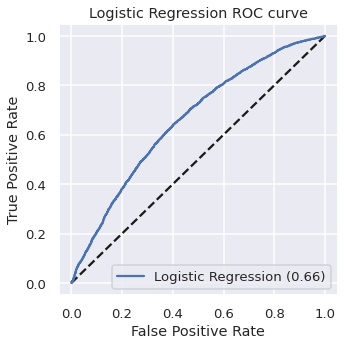

In [64]:
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_lr,tpr_lr, label='Logistic Regression (%0.2f)' % roc_auc_score(y_test,y_lr_predict_pro))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve')
plt.legend()
plt.show()

In [65]:
precision_lr, recall_lr, thresholds = precision_recall_curve(y_test,y_lr_predict_pro)

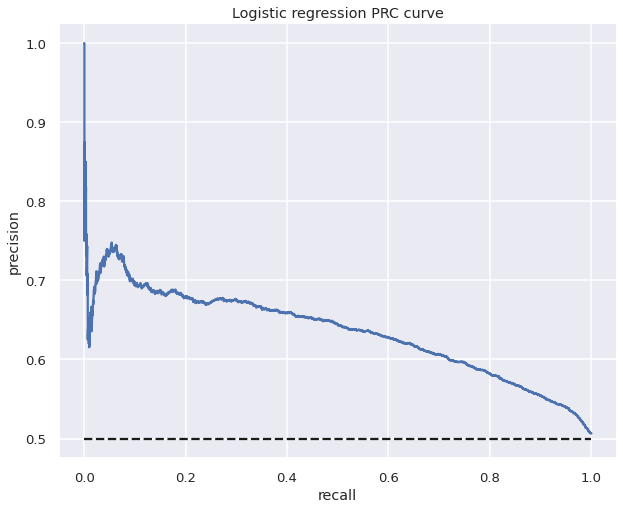

In [66]:
#precision & recall
plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5, 0.5],'k--')
plt.plot(recall_lr, precision_lr, label = 'Logistic regression')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Logistic regression PRC curve')
plt.show()

#Decision Tree Classifier

In [67]:
dt_scores = []
for i in range(1, len(X.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    dt_classifier.fit(X_train, y_train)
    dt_scores.append(round(dt_classifier.score(X_test, y_test),2))

Text(0.5, 1.0, 'Decision Tree Classifier scores for different number of maximum features')

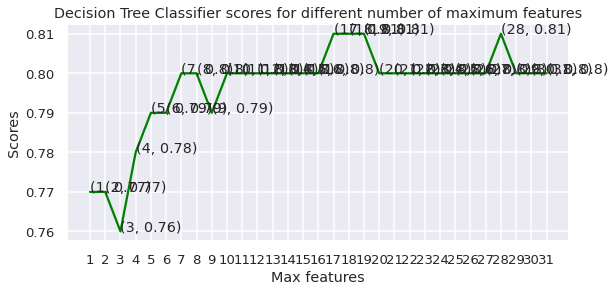

In [68]:
plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores, color = 'green')
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')

In [69]:
y_dt_predict_train = dt_classifier.predict(X_train)
y_dt_predict_test = dt_classifier.predict(X_test)

In [70]:
y_dt_predict_pro=dt_classifier.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_dt_predict_pro)

In [71]:
# Get the confusion matrix for  test 
print(f"Decision Tree confucing matrix is: \n {confusion_matrix(y_test, y_dt_predict_test)}")

Decision Tree confucing matrix is: 
 [[3602 1011]
 [ 865 3868]]


In [72]:
# Get the confusion matrix for  train 
print(f"Decision Tree confucing matrix is: \n {confusion_matrix(y_train, y_dt_predict_train)}")

Decision Tree confucing matrix is: 
 [[18751     0]
 [    0 18631]]


In [73]:
validation_matrix(y_train, y_dt_predict_train,
                  y_test, y_dt_predict_test,
                  y_dt_predict_pro,
                  model_name = "Decision tree")

scoring matrix for Decision tree
The accuracy on train data is  1.0
The accuracy on test data is  0.799
The precision on train data is  1.0
The precision on test data is  0.793
The recall on train data is  1.0
The recall on test data is  0.817
The f1-score on train data is  1.0
The f1-score on test data is  0.805
 ROC AUC score: 0.799


In [74]:
features = X.columns
importances = dt_classifier.feature_importances_
indices = np.argsort(importances)

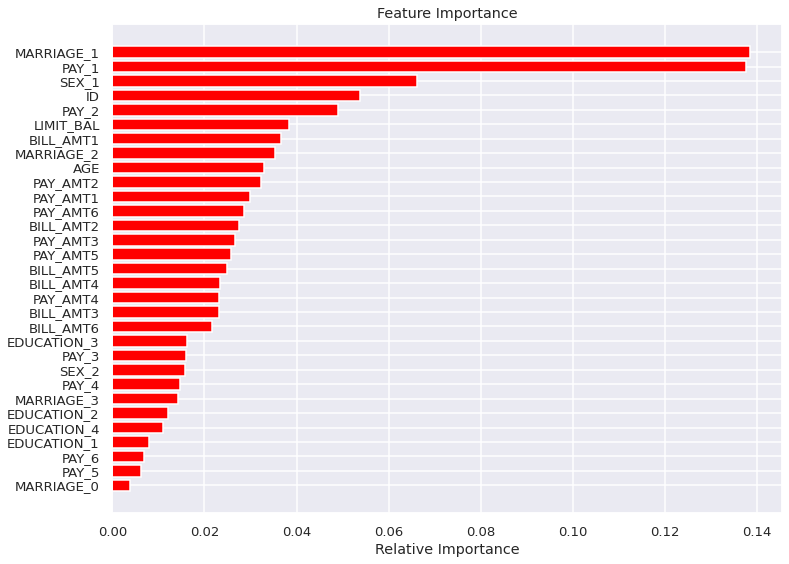

In [75]:
plt.figure(figsize=(12,9))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Random forest

In [76]:
classifier = RandomForestClassifier() # For GBM, use GradientBoostingClassifier()
grid_values = {'n_estimators':[50, 65, 80, 95,120], 'max_depth':[3, 5, 7,9,12]}
GSclassifier = GridSearchCV(classifier, param_grid = grid_values, scoring = 'roc_auc', cv=5)

# Fit the object to train dataset
GSclassifier.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 12],
                         'n_estimators': [50, 65, 80, 95, 120]},
             scoring='roc_auc')

In [77]:
bestvalues=GSclassifier.best_params_
GSclassifier.best_params_


{'max_depth': 12, 'n_estimators': 120}

In [78]:
classifier = RandomForestClassifier(max_depth=bestvalues['max_depth'],n_estimators=bestvalues['n_estimators']) # For GBM, use GradientBoostingClassifier()

classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=120)

In [79]:
y_train_preds_rf =  classifier.predict(X_train)
y_test_preds_rf= classifier.predict(X_test)

In [80]:
y_rf_predict_pro=classifier.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_rf_predict_pro)

In [81]:
# Get the confusion matrix for  train 
print(f"Random forest confucing matrix is: \n {confusion_matrix(y_train, y_train_preds_rf)}")
# Get the confusion matrix for  test
print(f"Random forest confucing matrix is: \n {confusion_matrix(y_test, y_test_preds_rf)}")

Random forest confucing matrix is: 
 [[17855   896]
 [ 2772 15859]]
Random forest confucing matrix is: 
 [[4201  412]
 [ 908 3825]]


In [82]:
validation_matrix(y_train, y_train_preds_rf,
                  y_test, y_test_preds_rf,
                  y_rf_predict_pro,
                  model_name = "Random forest")

scoring matrix for Random forest
The accuracy on train data is  0.902
The accuracy on test data is  0.859
The precision on train data is  0.947
The precision on test data is  0.903
The recall on train data is  0.851
The recall on test data is  0.808
The f1-score on train data is  0.896
The f1-score on test data is  0.853
 ROC AUC score: 0.925


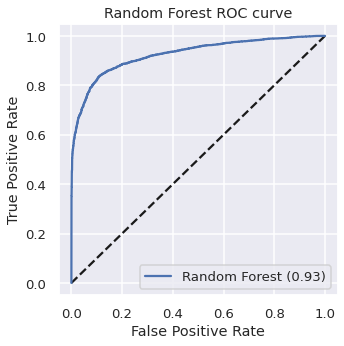

In [83]:
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rf,tpr_rf, label='Random Forest (%0.2f)' % roc_auc_score(y_test,y_rf_predict_pro))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
plt.legend()
plt.show()

### feature importance

In [84]:
features = X.columns
importances = classifier.feature_importances_
indices = np.argsort(importances)

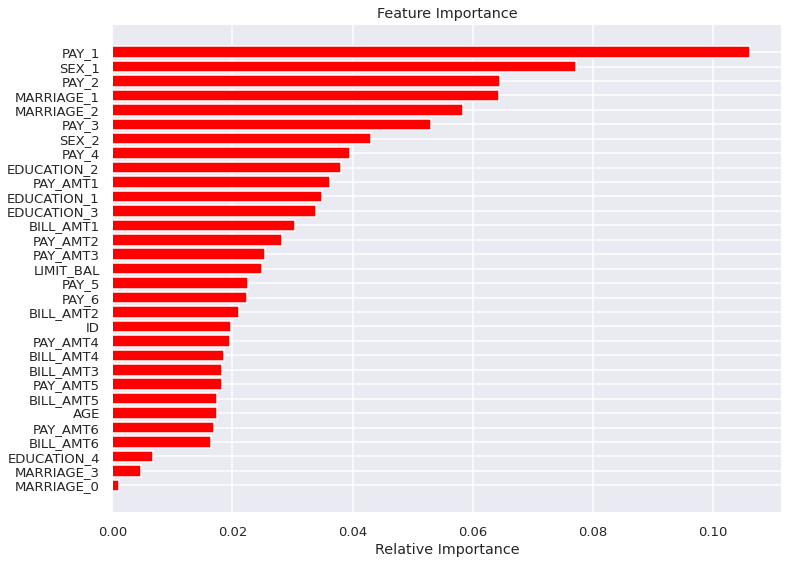

In [85]:
plt.figure(figsize=(12,9))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## KNN

In [86]:
param_grid = {'n_neighbors':np.arange(1,50)}

In [87]:
knn = KNeighborsClassifier() #cv different parameter
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_sm,y_sm)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [88]:
bestPermet=knn_cv.best_params_
knn_cv.best_params_

{'n_neighbors': 1}

In [89]:
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,30)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

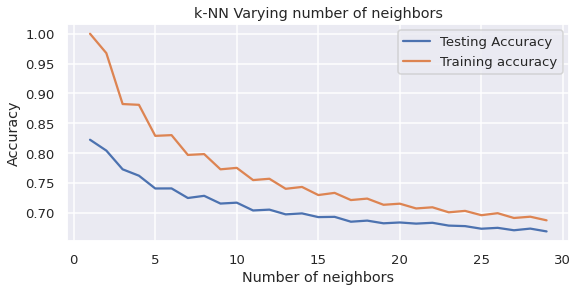

In [90]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [91]:
# Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=bestPermet['n_neighbors'])

In [92]:
# Fit the model
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [93]:
knn.score(X_test,y_test)

0.8224909052000856

In [94]:
y_test_pred_knn = knn.predict(X_test)
y_train_pred_knn = knn.predict(X_train)

In [95]:
# Get the confusion matrix for test
print(f"KNN confucing matrix is: \n {confusion_matrix(y_test,y_test_pred_knn)}")
# Get the confusion matrix for  train  
print(f"KNN confucing matrix is: \n {confusion_matrix(y_train,y_train_pred_knn)}")

KNN confucing matrix is: 
 [[3239 1374]
 [ 285 4448]]
KNN confucing matrix is: 
 [[18751     0]
 [    0 18631]]


In [96]:
y_pred_proba = knn.predict_proba(X_test)[:,1]

In [97]:
validation_matrix(y_train, y_train_pred_knn ,
                  y_test, y_test_pred_knn ,
                  y_pred_proba,
                  model_name="knn")

scoring matrix for knn
The accuracy on train data is  1.0
The accuracy on test data is  0.822
The precision on train data is  1.0
The precision on test data is  0.764
The recall on train data is  1.0
The recall on test data is  0.94
The f1-score on train data is  1.0
The f1-score on test data is  0.843
 ROC AUC score: 0.821


In [98]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba)

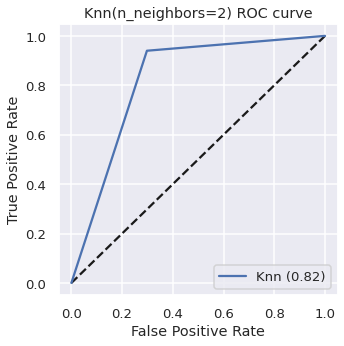

In [99]:
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_knn,tpr_knn, label='Knn (%0.2f)' % roc_auc_score(y_test,y_pred_proba))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Knn(n_neighbors=2) ROC curve')
plt.legend()
plt.show()

## cat boost

In [100]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [101]:
from catboost import CatBoostClassifier

In [102]:
catboost=CatBoostClassifier(iterations=100,learning_rate=0.03)

In [103]:
catboost.fit(X_train,y_train,verbose=10)

0:	learn: 0.6654264	total: 71.4ms	remaining: 7.07s
10:	learn: 0.5188642	total: 217ms	remaining: 1.75s
20:	learn: 0.4556542	total: 363ms	remaining: 1.36s
30:	learn: 0.4164135	total: 508ms	remaining: 1.13s
40:	learn: 0.3954248	total: 652ms	remaining: 938ms
50:	learn: 0.3787399	total: 801ms	remaining: 770ms
60:	learn: 0.3689293	total: 1.03s	remaining: 657ms
70:	learn: 0.3634083	total: 1.29s	remaining: 528ms
80:	learn: 0.3572637	total: 1.42s	remaining: 334ms
90:	learn: 0.3507989	total: 1.56s	remaining: 154ms
99:	learn: 0.3476720	total: 1.7s	remaining: 0us


In [104]:
y_catboost_pred_test=catboost.predict(X_test)
y_catboost_pred_train=catboost.predict(X_train)

In [105]:
# Get the confusion matrix for test
print(f"CATBOOST confucing matrix is: \n {confusion_matrix(y_test,y_catboost_pred_test)}")
# Get the confusion matrix for  train  
print(f"CATBOOST confucing matrix is: \n {confusion_matrix(y_train,y_catboost_pred_train)}")

CATBOOST confucing matrix is: 
 [[4259  354]
 [ 988 3745]]
CATBOOST confucing matrix is: 
 [[17429  1322]
 [ 3867 14764]]


In [106]:
y_catboost_pre_prob=catboost.predict_proba(X_test)[:,1]

In [107]:
catboost.score(X_test,y_test)

0.856409158998502

In [108]:
validation_matrix(y_train, y_catboost_pred_train ,
                  y_test, y_catboost_pred_test ,
                  y_catboost_pre_prob,
                  model_name = "CatBoost")

scoring matrix for CatBoost
The accuracy on train data is  0.861
The accuracy on test data is  0.856
The precision on train data is  0.918
The precision on test data is  0.914
The recall on train data is  0.792
The recall on test data is  0.791
The f1-score on train data is  0.851
The f1-score on test data is  0.848
 ROC AUC score: 0.919


In [109]:
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_test, y_catboost_pre_prob)

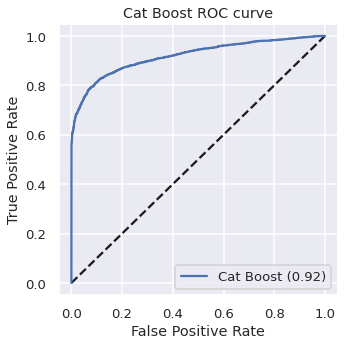

In [110]:
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_cat,tpr_cat, label='Cat Boost (%0.2f)' % roc_auc_score(y_test,y_catboost_pre_prob))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cat Boost ROC curve')
plt.legend()
plt.show()

##LIGHTGBM

In [111]:
import lightgbm as lgb

In [112]:
lightGBM = lgb.LGBMClassifier(silent=False)

In [113]:
#cv different parameter
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }
grid_search = GridSearchCV(lightGBM, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)


In [114]:
light_boost = grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [115]:
light_boost.best_params_

{'learning_rate': 0.1,
 'max_depth': 75,
 'n_estimators': 200,
 'num_leaves': 1200}

In [116]:
y_light_gbm_pred_train = light_boost.predict(X_train)
y_light_gbm_pred_test = light_boost.predict(X_test)


In [117]:
y_light_gbm_pre_prob = light_boost.predict_proba(X_test)[:,1]

In [118]:
light_boost.score(X_test,y_test)

0.9423761717693165

In [119]:
# Get the confusion matrix for test
print(f"LIGHTGBM confucing matrix is: \n {confusion_matrix(y_train,y_light_gbm_pred_train )}")
# Get the confusion matrix for  train  
print(f"LIGHTGBM confucing matrix is: \n {confusion_matrix(y_test,y_light_gbm_pred_test )}")

LIGHTGBM confucing matrix is: 
 [[18751     0]
 [    0 18631]]
LIGHTGBM confucing matrix is: 
 [[4274  339]
 [ 779 3954]]


In [120]:
validation_matrix(y_train, y_light_gbm_pred_train ,
                  y_test, y_light_gbm_pred_test ,
                  y_light_gbm_pre_prob ,
                  model_name = "Light GBM")

scoring matrix for Light GBM
The accuracy on train data is  1.0
The accuracy on test data is  0.88
The precision on train data is  1.0
The precision on test data is  0.921
The recall on train data is  1.0
The recall on test data is  0.835
The f1-score on train data is  1.0
The f1-score on test data is  0.876
 ROC AUC score: 0.942


In [121]:
fpr_lGBM, tpr_lGBM, thresholds_lGBM = roc_curve(y_test, y_light_gbm_pre_prob)

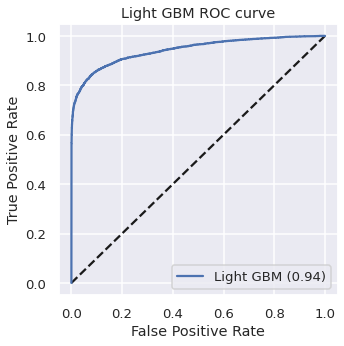

In [122]:
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_lGBM,tpr_lGBM, label='Light GBM (%0.2f)' % roc_auc_score(y_test, y_light_gbm_pre_prob))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Light GBM ROC curve')
plt.legend()
plt.show()

##feature importance

In [123]:
features = X.columns
importances = light_boost.best_estimator_.feature_importances_
indices = np.argsort(importances)

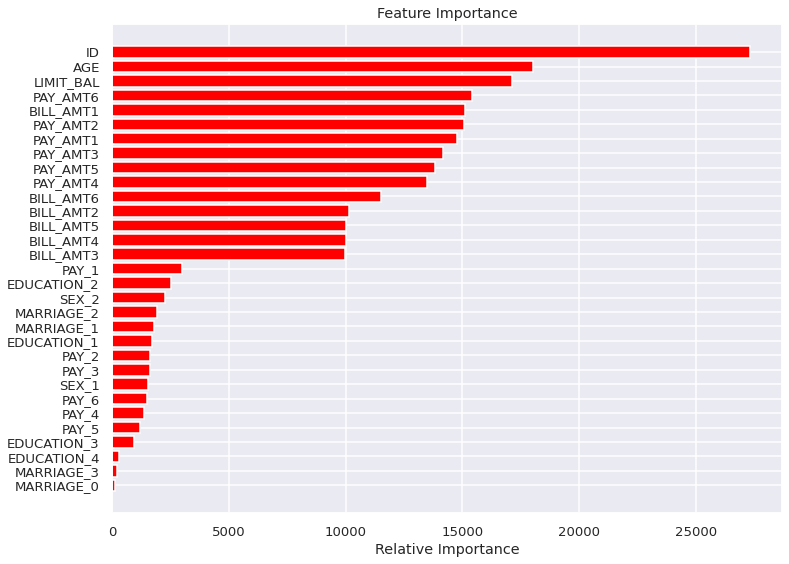

In [124]:
plt.figure(figsize=(12,9))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# model performance

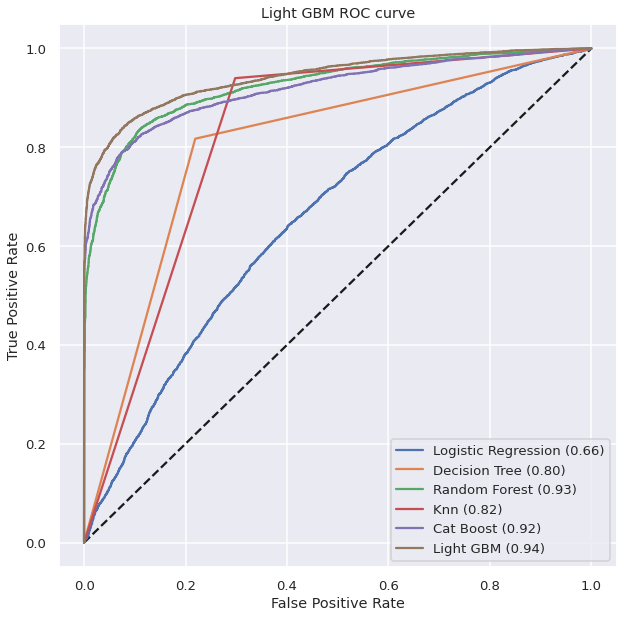

In [125]:
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_lr,tpr_lr, label='Logistic Regression (%0.2f)' % roc_auc_score(y_test,y_lr_predict_pro))
plt.plot(fpr_dt,tpr_dt, label='Decision Tree (%0.2f)' % roc_auc_score(y_test,y_dt_predict_pro))
plt.plot(fpr_rf,tpr_rf, label='Random Forest (%0.2f)' % roc_auc_score(y_test,y_rf_predict_pro))
plt.plot(fpr_knn,tpr_knn, label='Knn (%0.2f)' % roc_auc_score(y_test,y_pred_proba))
#plt.plot(fpr_svm,tpr_svm, label='SVM (%0.2f)' % roc_auc_score(y_test,y_svm_predict_pro))
plt.plot(fpr_cat,tpr_cat, label='Cat Boost (%0.2f)' % roc_auc_score(y_test,y_catboost_pre_prob))
plt.plot(fpr_lGBM,tpr_lGBM, label='Light GBM (%0.2f)' % roc_auc_score(y_test, y_light_gbm_pre_prob))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Light GBM ROC curve')
plt.legend()
plt.show()

In [126]:
#creating dictionary to store all the metrices 
dict={'Train Accuracy':train_accuracy_list,'Test accuracy':test_accuracy_list,
      'Precision Train ':precision_train_list ,'Precision_Test ':precision_test_list ,
      'Recall Train':Recall_train_list,'Recall Test':Recall_test_list,
      'ROC AUC Test':ROC_AUC_test_list}

In [127]:
# list of all models
model_name=['Logistic',"Decision Tree","Random forest",'KNN','Cat Boost','Light GBM']

In [128]:
# converting dictionary to dataframe
matrix_df=pd.DataFrame.from_dict(dict,orient="index",columns=model_name)

In [129]:
# taking the transpose of the dataframe to make it more visual appealing
matrix_df.transpose().reset_index().rename(columns={'index':'Models'})

,Models,Train Accuracy,Test accuracy,Precision Train,Precision_Test,Recall Train,Recall Test,ROC AUC Test
0,Logistic,0.615,0.618,0.610,0.620,0.630,0.632,0.658
1,Decision Tree,1.000,0.799,1.000,0.793,1.000,0.817,0.799
2,Random forest,0.902,0.859,0.947,0.903,0.851,0.808,0.925
3,KNN,1.000,0.822,1.000,0.764,1.000,0.940,0.821
4,Cat Boost,0.861,0.856,0.918,0.914,0.792,0.791,0.919
5,Light GBM,1.000,0.880,1.000,0.921,1.000,0.835,0.942
